In [1]:
from SimulateDay import stock_market_simulation, scale_data,train_Optimal_Action, _select_stock, get_stock_data, add_columns, train_Optimal_Action
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import numpy as np 
import pandas as pd
import joblib
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

def importModels(symbol):
    specificModel = joblib.load(f"models/{symbol}_model.pkl")
    noCovidModel = train_Optimal_Action(symbol=symbol, action_column='Action')
    generalModel = xgb.Booster()    
    generalModel.load_model('models/all_stocks_incremental_model.pkl') 
    return specificModel, generalModel, noCovidModel


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


In [2]:

specificModel, generalModel, noCovidModel = importModels('TSLA')


Loading data for TSLA ...
Adding columns for TSLA...


/Users/eduardobenjamin/Desktop/Repos/MachineLearningProjects/Stock-Market-Analysis+Model/SimulateDay.py:238: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  '10_Day_Return', '20_Day_Return', '50_Day_Return', '200_Day_Return']].idxmax(axis=1)
/Users/eduardobenjamin/Desktop/Repos/MachineLearningProjects/Stock-Market-Analysis+Model/SimulateDay.py:238: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  '10_Day_Return', '20_Day_Return', '50_Day_Return', '200_Day_Return']].idxmax(axis=1)


ValueError: Input X contains infinity or a value too large for dtype('float64').

In [5]:
features = ['Volume', 'MA_10', 'MA_20', 'MA_50', 'MA_200', 'std_10',
                'std_20', 'std_50', 'std_200', 'upper_band_10', 'lower_band_10',
                'upper_band_20', 'lower_band_20', 'upper_band_50', 'lower_band_50',
                'upper_band_200', 'lower_band_200', 'Golden_Cross_Short', 'Golden_Cross_Medium',
                'Golden_Cross_Long', 'Death_Cross_Short', 'Death_Cross_Medium', 'Death_Cross_Long',
                'ROC', 'AVG_Volume_10', 'AVG_Volume_20', 'AVG_Volume_50', 'AVG_Volume_200', 'Doji',
                'Bullish_Engulfing', 'Bearish_Engulfing', 'MACD', 'Signal', 'MACD_Hist', 'TR', 'ATR',
                'RSI_10_Day', '10_Day_ROC', 'Resistance_10_Day', 'Support_10_Day', 'Resistance_20_Day',
                'Support_20_Day', 'Resistance_50_Day', 'Support_50_Day', 'Volume_MA_10', 'Volume_MA_20',
                'Volume_MA_50', 'OBV', 'Z-score',]

In [2]:
def train_classification_models_basic(X_train, y_train, X_test, y_test):
    models = {
        "Logistic Regression": LogisticRegression(random_state=42),
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
        "SVM": SVC(random_state=42),
        "XGBoost": xgb.XGBClassifier(n_estimators=100, random_state=42),
        "Stacking": StackingClassifier(
            estimators=[
                ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
                ('xgb', xgb.XGBClassifier(n_estimators=100, random_state=42)),
            ],
            final_estimator=xgb.XGBClassifier(n_estimators=100, random_state=42)
        )
    }
    
    results = {}
    
    for name, model in models.items():
        print(f"Training {name}...")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, output_dict=True)
        
        results[name] = {
            "Model": model,
            "Accuracy": accuracy,
            "Classification Report": report
        }
        
        print(f"--- {name} Results ---")
        print(f"Accuracy: {accuracy}")
        print(classification_report(y_test, y_pred))
    
    return results
def train_classification_model_tuned(X_train, y_train, X_test, y_test):
    models = {
        "Logistic Regression Tuned": LogisticRegression(C=1.0, penalty='l2', solver='saga', max_iter=1000, random_state=42),
        "Random Forest Tuned": RandomForestClassifier(n_estimators=200, max_depth=20, min_samples_split=10, min_samples_leaf=5, max_features='sqrt', random_state=42),
        "SVM Tuned ": SVC(random_state=42, C=10.0, kernel='rbf',gamma='scale'),
        "XGBoost Tuned": xgb.XGBClassifier(n_estimators=200, learning_rate=0.05, max_depth=6, subsample=0.8, colsample_bytree=0.8, gamma=0.1, random_state=42),
    }
    
    results = {}
    
    for name, model in models.items():
        print(f"Training {name}...")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, output_dict=True)
        
        results[name] = {
            "Model": model,
            "Accuracy": accuracy,
            "Classification Report": report
        }
        
        print(f"--- {name} Results ---")
        print(f"Accuracy: {accuracy}")
        print(classification_report(y_test, y_pred))
    
    return results



In [3]:
def run_simulations_on_models(X_train, y_train, X_test, y_test, stock_data, initial_cash, days):
    # Train different models
    trained_models = train_classification_models_basic(X_train, y_train, X_test, y_test)
    # trained_models_tuned = train_classification_models_basic(X_train, y_train, X_test, y_test)
    # trained_models = {**trained_models_basic, **trained_models_tuned}    
    # # Dictionary to store simulation results for each model
    simulation_results = {}
    
    # Run stock market simulation for each trained model
    for model_name, model_data in trained_models.items():
        model = model_data['Model']
        print(f"Running stock market simulation for {model_name}...")
        
        # Run the simulation
        simulation_df, final_cash = stock_market_simulation(model, initial_cash, days, stock_data)
        
        # Store the simulation results
        simulation_results[model_name] = simulation_df
        
    return simulation_results

In [7]:
# stock_df = get_stock_data('TSLA')
# print(f'Adding columns...')
stock_df = pd.read_csv('data/sp500_stocks.csv')
stock_df = stock_df[stock_df['Symbol'] == 'TSLA']
print(f'Scaling data...')
preprocessed = scale_data(stock_df)
X = preprocessed[features]
y = stock_df['Action']
# y = y.map({'Buy': 0, 'Sell': 1, 'Hold': 2})
X_train, _, y_train, _ = train_test_split(
    X, y, test_size=0.2, random_state=42)

Scaling data...


/Users/eduardobenjamin/Desktop/Repos/MachineLearningProjects/Stock-Market-Analysis+Model/SimulateDay.py:238: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  '10_Day_Return', '20_Day_Return', '50_Day_Return', '200_Day_Return']].idxmax(axis=1)


In [33]:
simResults = run_simulations_on_models(X_train, y_train, X_train, y_train,get_stock_data('TSLA').tail(365) , 10000, 365)

Training Logistic Regression...


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


--- Logistic Regression Results ---
Accuracy: 0.8644922663080027
              precision    recall  f1-score   support

           0       0.84      0.88      0.86      1045
           1       0.84      0.84      0.84       797
           2       0.90      0.87      0.89      1132

    accuracy                           0.86      2974
   macro avg       0.86      0.86      0.86      2974
weighted avg       0.87      0.86      0.86      2974

Training Random Forest...
--- Random Forest Results ---
Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1045
           1       1.00      1.00      1.00       797
           2       1.00      1.00      1.00      1132

    accuracy                           1.00      2974
   macro avg       1.00      1.00      1.00      2974
weighted avg       1.00      1.00      1.00      2974

Training SVM...
--- SVM Results ---
Accuracy: 0.8375924680564896
              precision    recall  f1-

/Users/eduardobenjamin/Desktop/Repos/MachineLearningProjects/Stock-Market-Analysis+Model/SimulateDay.py:238: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  '10_Day_Return', '20_Day_Return', '50_Day_Return', '200_Day_Return']].idxmax(axis=1)
/Users/eduardobenjamin/Desktop/Repos/MachineLearningProjects/Stock-Market-Analysis+Model/SimulateDay.py:143: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  modelDecisionDf = pd.concat(


Running stock market simulation for Random Forest...


/Users/eduardobenjamin/Desktop/Repos/MachineLearningProjects/Stock-Market-Analysis+Model/SimulateDay.py:238: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  '10_Day_Return', '20_Day_Return', '50_Day_Return', '200_Day_Return']].idxmax(axis=1)
/Users/eduardobenjamin/Desktop/Repos/MachineLearningProjects/Stock-Market-Analysis+Model/SimulateDay.py:143: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  modelDecisionDf = pd.concat(


Running stock market simulation for SVM...


/Users/eduardobenjamin/Desktop/Repos/MachineLearningProjects/Stock-Market-Analysis+Model/SimulateDay.py:238: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  '10_Day_Return', '20_Day_Return', '50_Day_Return', '200_Day_Return']].idxmax(axis=1)
/Users/eduardobenjamin/Desktop/Repos/MachineLearningProjects/Stock-Market-Analysis+Model/SimulateDay.py:143: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  modelDecisionDf = pd.concat(


Running stock market simulation for XGBoost...


/Users/eduardobenjamin/Desktop/Repos/MachineLearningProjects/Stock-Market-Analysis+Model/SimulateDay.py:238: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  '10_Day_Return', '20_Day_Return', '50_Day_Return', '200_Day_Return']].idxmax(axis=1)
/Users/eduardobenjamin/Desktop/Repos/MachineLearningProjects/Stock-Market-Analysis+Model/SimulateDay.py:143: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  modelDecisionDf = pd.concat(


Running stock market simulation for Stacking...


/Users/eduardobenjamin/Desktop/Repos/MachineLearningProjects/Stock-Market-Analysis+Model/SimulateDay.py:238: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  '10_Day_Return', '20_Day_Return', '50_Day_Return', '200_Day_Return']].idxmax(axis=1)
/Users/eduardobenjamin/Desktop/Repos/MachineLearningProjects/Stock-Market-Analysis+Model/SimulateDay.py:143: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  modelDecisionDf = pd.concat(


/Users/eduardobenjamin/Desktop/Repos/MachineLearningProjects/Stock-Market-Analysis+Model/SimulateDay.py:237: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  '10_Day_Return', '20_Day_Return', '50_Day_Return', '200_Day_Return']].idxmax(axis=1)


Day 0: Bought 1 share at 168.5399932861328, Cash left: 9831.460006713867
Day 1: Bought 1 share at 167.4499969482422, Cash left: 9664.010009765625
Day 2: Bought 1 share at 165.7899932861328, Cash left: 9498.220016479492
Day 4: Bought 1 share at 173.5, Cash left: 9324.720016479492
Day 5: Bought 1 share at 171.77000427246094, Cash left: 9152.950012207031
Day 6: Bought 1 share at 173.55999755859375, Cash left: 8979.390014648438
Day 7: Bought 1 share at 173.75, Cash left: 8805.640014648438
Day 8: Bought 1 share at 172.57000732421875, Cash left: 8633.070007324219
Day 9: Bought 1 share at 172.07000732421875, Cash left: 8461.0
Day 10: Bought 1 share at 172.07000732421875, Cash left: 8288.929992675781
Day 11: Bought 1 share at 172.69000244140625, Cash left: 8116.239990234375
Day 12: Bought 1 share at 175.0500030517578, Cash left: 7941.189987182617
Day 13: Bought 1 share at 175.16000366210938, Cash left: 7766.029983520508
Day 14: Bought 1 share at 174.1999969482422, Cash left: 7591.829986572266


/Users/eduardobenjamin/Desktop/Repos/MachineLearningProjects/Stock-Market-Analysis+Model/SimulateDay.py:142: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  modelDecisionDf = pd.concat(


Day 17: Bought 1 share at 172.99000549316406, Cash left: 7075.439987182617
Day 18: Bought 1 share at 175.42999267578125, Cash left: 6900.009994506836
Day 19: Bought 1 share at 177.3000030517578, Cash left: 6722.709991455078
Day 20: Bought 1 share at 177.25, Cash left: 6545.459991455078
Day 21: Bought 1 share at 180.08999633789062, Cash left: 6365.3699951171875
Day 22: Bought 1 share at 180.9499969482422, Cash left: 6184.419998168945
Day 23: Bought 1 share at 179.5800018310547, Cash left: 6004.839996337891
Day 24: Bought 1 share at 179.2100067138672, Cash left: 5825.629989624023
Day 25: Bought 1 share at 177.82000732421875, Cash left: 5647.809982299805
Day 26: Bought 1 share at 180.57000732421875, Cash left: 5467.239974975586
Day 27: Bought 1 share at 180.9600067138672, Cash left: 5286.279968261719
Day 28: Bought 1 share at 183.7899932861328, Cash left: 5102.489974975586
Day 29: Bought 1 share at 183.30999755859375, Cash left: 4919.179977416992
Day 30: Bought 1 share at 183.949996948242

<Axes: >

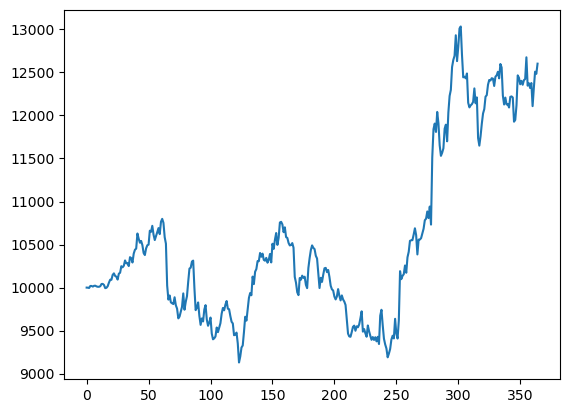

In [4]:
specific_model = joblib.load('models/AAPL_model.pkl')
# specific_model = train_Optimal_Action(symbol='MSFT', action_column='Action')
specificdf = stock_market_simulation(specific_model, 10000, 365, get_stock_data('AAPL').tail(365), print_results=True)


<Axes: title={'center': 'Portfolio Value'}>

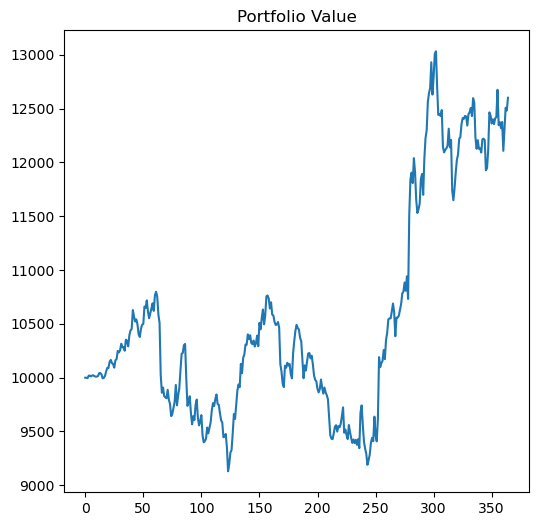

In [7]:
specificdf[0]['Portfolio Value'].plot(figsize=(6, 6), title='Portfolio Value')

In [34]:
simResults['Logistic Regression']
simResults['Random Forest']
simResults['Stacking']
# simResults['SVM']
# simResults['XGBoost']

,Stock Name,Day,Action,Cash,Shares Held,Portfolio Value,Stock Price,Date
0,TSLA,0,Buy,9839.690002,1,10000.000000,160.309998,2023-05-02
1,TSLA,1,Buy,9679.080002,2,10000.300003,160.610001,2023-05-03
2,TSLA,2,Buy,9517.880005,3,10001.479996,161.199997,2023-05-04
3,TSLA,3,Hold,9517.880005,3,10028.059998,170.059998,2023-05-05
4,TSLA,4,Hold,9517.880005,3,10033.249985,171.789993,2023-05-08
...,...,...,...,...,...,...,...,...
360,TSLA,360,Sell,240.830002,48.330201,11880.192349,240.830002,2024-10-07
361,TSLA,361,Hold,240.830002,48.330201,12057.564098,244.500000,2024-10-08
362,TSLA,362,Sell,481.880005,47.330201,11890.825052,241.050003,2024-10-09
363,TSLA,363,Sell,720.650009,46.330201,11782.912252,238.770004,2024-10-10


In [64]:
import pandas as pd

MODELCOMPARISON = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'SVM', 'XGBoost', 'Specific Model','Stacking',
              'Logistic Regression', 'Random Forest', 'SVM', 'XGBoost', 'Specific Model','Stacking',
              'Logistic Regression', 'Random Forest', 'SVM', 'XGBoost', 'Specific Model','Stacking',
              'Logistic Regression', 'Random Forest', 'SVM', 'XGBoost', 'Specific Model','Stacking',
              'Logistic Regression', 'Random Forest', 'SVM', 'XGBoost', 'Specific Model','Stacking',
              'Logistic Regression', 'Random Forest', 'SVM', 'XGBoost', 'Specific Model','Stacking',],
    'Stock': ['AAPL', 'AAPL', 'AAPL', 'AAPL', 'AAPL','AAPL',
              'MSFT', 'MSFT', 'MSFT', 'MSFT', 'MSFT', 'MSFT',
              'INTC', 'INTC', 'INTC', 'INTC', 'INTC', 'INTC',
              'GOOG', 'GOOG', 'GOOG', 'GOOG', 'GOOG', 'GOOG',
              'AMD', 'AMD', 'AMD', 'AMD', 'AMD', 'AMD',
              'TSLA', 'TSLA', 'TSLA', 'TSLA', 'TSLA', 'TSLA'],
    'Final Portfolio Value': [12010.10, 12438.13, 10991.26, 12404.69, 12404.69, 12560.38,
                              11677.37, 11187.02, 11803.34, 11808.35, 11774.20, 10278.36,
                              9921.06, 9981.07, 9822.93, 9981.07, 9252.78,9980.80,
                              9969.69, 9944.17, 9964.88, 9956.80, 11123.06, 9986.28,
                              10187.84, 9921.48, 10446.35, 9921.48, 10742.80,9920.74,
                              9144.12, 10501.23, 9193.88, 10614.61, 9016.84,10897.54],
    'Total Profit %': [20.01, 24.38, 9.91, 24.04, 24.04, 25.60,
                       16.77, 11.87, 18.03, 18.08, 17.74, 2.78,
                       -0.79, 0.81, -1.77, 0.81, -7.47, -0.20,
                       -0.30, -0.56, -0.35, -0.44, 11.23, -0.14,
                       1.19, -0.79, 4.46, -0.79, 7.43, -0.80,
                       -8.56, 5.01, -8.06, 6.14, -9.83, 8.98]
}).sort_values('Final Portfolio Value')
MODELCOMPARISON.to_csv('data/MODELCOMPARISON.csv')

In [195]:
import plotly.subplots as sp
import plotly.graph_objects as go

# Create subplots with 2 rows and 1 column
fig = sp.make_subplots(rows=2, cols=1, subplot_titles=('Final Portfolio Value', 'Stock Price'), shared_xaxes=True)

# Add trace for Portfolio Value in the first row
fig.add_trace(go.Scatter(x=specificdf[0]['Day'], y=specificdf[0]['Portfolio Value'],mode='lines', name='Specific Model'), row=1, col=1)

# Add trace for Stock Price in the first row
fig.add_trace(go.Scatter(x=specificdf[0]['Day'], y=specificdf[0]['Stock Price'], mode='lines', name='Stock Price'), row=2, col=1)

# Update layout for better visualization
fig.update_layout(height=600, width=800, title_text="Portfolio Analysis")

# Show the plot
fig.show()

In [190]:
specificdf[0]

,Stock Name,Day,Action,Cash,Shares Held,Portfolio Value,Stock Price,Date
0,TSLA,0,Hold,10000,0,10000.000000,160.309998,2023-05-02
1,TSLA,1,Hold,10000,0,10000.000000,160.610001,2023-05-03
2,TSLA,2,Hold,10000,0,10000.000000,161.199997,2023-05-04
3,TSLA,3,Hold,10000,0,10000.000000,170.059998,2023-05-05
4,TSLA,4,Hold,10000,0,10000.000000,171.789993,2023-05-08
...,...,...,...,...,...,...,...,...
360,TSLA,360,Sell,6332.320038,12,9222.280060,240.830002,2024-10-07
361,TSLA,361,Sell,6576.820038,11,9266.320038,244.500000,2024-10-08
362,TSLA,362,Sell,6817.870041,10,9228.370071,241.050003,2024-10-09
363,TSLA,363,Sell,7056.640045,9,9205.570084,238.770004,2024-10-10


In [5]:
# stock_df = get_stock_data('TSLA')
# print(f'Adding columns...')
stock_df = pd.read_csv('data/sp500_stocks_sector.csv')
stock_df = stock_df[stock_df['Symbol'] == 'AAPL']
print(f'Scaling data...')
preprocessed,features = scale_data(stock_df)
X = preprocessed[features]
y = stock_df['Action']
# y = y.map({'Buy': 0, 'Sell': 1, 'Hold': 2})
X_train, _, y_train, _ = train_test_split(
    X, y, test_size=0.2, random_state=42)
model = StackingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
        ('xgb', xgb.XGBClassifier(n_estimators=100, random_state=42)),
        # ("specificModel", joblib.load('models/MSFT_model.pkl'))
    ],
    final_estimator=xgb.XGBClassifier(n_estimators=100, random_state=42)
)

model.fit(X_train, y_train)


Scaling data...


/Users/eduardobenjamin/Desktop/Repos/MachineLearningProjects/Stock-Market-Analysis+Model/SimulateDay.py:237: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  '10_Day_Return', '20_Day_Return', '50_Day_Return', '200_Day_Return']].idxmax(axis=1)


['AAPL_model_Stacking_Sector.pkl']

In [7]:
# stock_df = pd.read_csv('data/sp500_stocks_sector.csv')
# sector = pd.get_dummies(stock_df['Sector']).astype(int)
# stock_df = pd.concat([stock_df, sector], axis=1)
# stock_df.to_csv('data/sp500_stocks_sector.csv', index=False)

Index(['Volume', 'MA_10', 'MA_20', 'MA_50', 'MA_200', 'std_10', 'std_20',
       'std_50', 'std_200', 'upper_band_10', 'lower_band_10', 'upper_band_20',
       'lower_band_20', 'upper_band_50', 'lower_band_50', 'upper_band_200',
       'lower_band_200', 'Golden_Cross_Short', 'Golden_Cross_Medium',
       'Golden_Cross_Long', 'Death_Cross_Short', 'Death_Cross_Medium',
       'Death_Cross_Long', 'ROC', 'AVG_Volume_10', 'AVG_Volume_20',
       'AVG_Volume_50', 'AVG_Volume_200', 'Doji', 'Bullish_Engulfing',
       'Bearish_Engulfing', 'MACD', 'Signal', 'MACD_Hist', 'TR', 'ATR',
       'RSI_10_Day', '10_Day_ROC', 'Resistance_10_Day', 'Support_10_Day',
       'Resistance_20_Day', 'Support_20_Day', 'Resistance_50_Day',
       'Support_50_Day', 'Volume_MA_10', 'Volume_MA_20', 'Volume_MA_50', 'OBV',
       'Z-score', 'Basic Materials', 'Communication Services',
       'Consumer Cyclical', 'Consumer Defensive', 'Energy',
       'Financial Services', 'Healthcare', 'Industrials', 'Real Estate',
  

In [2]:
stock_market_simulation(model, 10000, 365, get_stock_data('AAPL').tail(365), print_results=True)

/Users/eduardobenjamin/Desktop/Repos/MachineLearningProjects/Stock-Market-Analysis+Model/SimulateDay.py:237: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  '10_Day_Return', '20_Day_Return', '50_Day_Return', '200_Day_Return']].idxmax(axis=1)


ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- Basic Materials
- Communication Services
- Consumer Cyclical
- Consumer Defensive
- Energy
- ...
